# Thicket and Extra-P: Thicket Tutorial

Thicket is a python-based toolkit for Exploratory Data Analysis (EDA) of parallel performance data that enables performance optimization and understanding of applications’ performance on supercomputers. It bridges the performance tool gap between being able to consider only a single instance of a simulation run (e.g., single platform, single measurement tool, or single scale) and finding actionable insights in multi-dimensional, multi-scale, multi-architecture, and multi-tool performance datasets.

#### NOTE: An interactive version of this notebook is available in the Binder environment.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/llnl/thicket-tutorial/develop)

# Thicket Modeling Example

This notebook provides an example for using Thicket's modeling feature. The modeling capability relies on _Extra-P_ - a tool for empirical performance modeling. It can perform N-parameter modeling with up to 3 parameters (N <= 3). The models follow a so-called _Performance Model Normal Form (PMNF)_ that expresses models as a summation of polynomial and logarithmic terms. One of the biggest advantages of this modeling method is that the produced models are human-readable and easily understandable.

***

## 1. Import Necessary Packages

To explore the capabilities of thicket with Extra-P, we begin by importing necessary packages.

In [13]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from IPython.display import HTML

import thicket as th
from thicket.model_extrap import Modeling

display(HTML("<style>.container { width:80% !important; }</style>"))

## 2. Define Dataset Paths and Names

In this example, we use an MPI scaling study, profiled with Caliper, that has metadata about the runs. The data is also already aggregated, which means we can provide the data to Extra-P as-is.

In [33]:
data = "../data/lulesh/weak"
t_ens = th.Thicket.from_caliperreader(data)

Specifically, the metadata table for this set of profiles contains a `jobsize` column, which provides the amount of cores used for each profile.

In [34]:
t_ens.metadata

,cali.caliper.version,spot.metrics,spot.timeseries.metrics,spot.format.version,spot.options,spot.channels,cali.channel,user,launchdate,executablepath,...,problem_size,num_regions,region_cost,region_balance,Compiler Name,Compiler Version,Built by,Compiler Flags,elapsed_time,figure_of_merit
profile,,,,,,,,,,,,,,,,,,,,,
73920447,2.10.0-dev,"min#inclusive#sum#time.duration,max#inclusive#...",,2,node.order,regionprofile,spot,ritter5,1692219904,/usr/WS2/ritter5/LULESH/build/lulesh2.0,...,30,11,1,1,GNU,10.3.1,ritter5,,179.086442,41143.214966
76581708,2.10.0-dev,"min#inclusive#sum#time.duration,max#inclusive#...",,2,node.order,regionprofile,spot,ritter5,1692655987,/usr/WS2/ritter5/LULESH/build/lulesh2.0,...,30,11,1,1,GNU,10.3.1,ritter5,,345.928735,204105.230211
362934985,2.10.0-dev,"min#inclusive#sum#time.duration,max#inclusive#...",,2,node.order,regionprofile,spot,ritter5,1692305004,/usr/WS2/ritter5/LULESH/build/lulesh2.0,...,30,11,1,1,GNU,10.3.1,ritter5,,298.020504,127179.732370
429845606,2.10.0-dev,"min#inclusive#sum#time.duration,max#inclusive#...",,2,node.order,regionprofile,spot,ritter5,1692304776,/usr/WS2/ritter5/LULESH/build/lulesh2.0,...,30,11,1,1,GNU,10.3.1,ritter5,,123.774502,18523.241558
747032671,2.10.0-dev,"min#inclusive#sum#time.duration,max#inclusive#...",,2,node.order,regionprofile,spot,ritter5,1692304789,/usr/WS2/ritter5/LULESH/build/lulesh2.0,...,30,11,1,1,GNU,10.3.1,ritter5,,178.083930,41374.828091
1006620604,2.10.0-dev,"min#inclusive#sum#time.duration,max#inclusive#...",,2,node.order,regionprofile,spot,ritter5,1692305343,/usr/WS2/ritter5/LULESH/build/lulesh2.0,...,30,11,1,1,GNU,10.3.1,ritter5,,300.014906,126334.282699
1029694624,2.10.0-dev,"min#inclusive#sum#time.duration,max#inclusive#...",,2,node.order,regionprofile,spot,ritter5,1692304935,/usr/WS2/ritter5/LULESH/build/lulesh2.0,...,30,11,1,1,GNU,10.3.1,ritter5,,227.845351,79721.837131
1092599044,2.10.0-dev,"min#inclusive#sum#time.duration,max#inclusive#...",,2,node.order,regionprofile,spot,ritter5,1692304784,/usr/WS2/ritter5/LULESH/build/lulesh2.0,...,30,11,1,1,GNU,10.3.1,ritter5,,123.236121,18604.163998
1102127705,2.10.0-dev,"min#inclusive#sum#time.duration,max#inclusive#...",,2,node.order,regionprofile,spot,ritter5,1692219523,/usr/WS2/ritter5/LULESH/build/lulesh2.0,...,30,11,1,1,GNU,10.3.1,ritter5,,27.992272,15672.039691


## 3. More Information on a Function
***
You can use the `help()` method within Python to see the information for a given object. You can do this by typing `help(object)`. 
This will allow you to see the arguments for the function, and what will be returned. An example is below.

In [36]:
help(Modeling)

Help on class Modeling in module thicket.model_extrap:

class Modeling(builtins.object)
 |  Modeling(tht, param_name, params=None, chosen_metrics=None)
 |  
 |  Produce models for all the metrics across the given graphframes.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, tht, param_name, params=None, chosen_metrics=None)
 |      Create a new model object.
 |      
 |      Adds a model column for each metric for each common frame across all the
 |      graphframes.
 |      
 |      The given list of params contains the parameters to build the models.  For
 |      example, MPI ranks, input sizes, and so on.
 |      
 |      Arguments:
 |          tht (Thicket): thicket object
 |          param_name (str): arbitrary if 'params' is being provided, otherwise name of
 |              the metadata column from which 'params' will be extracted
 |          params (list): parameters list, domain for the model
 |          chosen_metrics (list): metrics to be evaluated in the model, range f

## 3. Create Models

First, we construct the `Modeling` object by passing all the relevant data to it. We provide `jobsize` as the `param_name` argument so the model will grab this column from the metadata table to use as our parameter. We also sub-select some metrics, since this dataset has a lot of metrics (otherwise the modeling will take a long time to do all metrics).

Then, we call `produce_models` on that object (it's unnecessary to provide an aggregation function since the data is already aggregated.).

**NOTE:** For this example, you can view all the metric columns by adding a new cell and running: `t_ens.performance_cols`. 

In [37]:
mdl = Modeling(
    t_ens,
    "jobsize",
    chosen_metrics=[
        "Avg time/rank",
        "Total time",
    ],
)

mdl.produce_models()

self.param_name: jobsize
coordinates: [Coordinate(64.0,), Coordinate(343.0,), Coordinate(216.0,), Coordinate(27.0,), Coordinate(125.0,), Coordinate(8.0,)]
len coordinates: 6
Callpaths: [Callpath(main), Callpath(CommRecv), Callpath(CommSBN), Callpath(CommSend), Callpath(lulesh.cycle), Callpath(LagrangeLeapFrog), Callpath(CalcTimeConstraintsForElems), Callpath(LagrangeElements), Callpath(ApplyMaterialPropertiesForElems), Callpath(EvalEOSForElems), Callpath(CalcEnergyForElems), Callpath(CalcLagrangeElements), Callpath(CalcKinematicsForElems), Callpath(CalcQForElems), Callpath(CalcMonotonicQForElems), Callpath(CommMonoQ), Callpath(LagrangeNodal), Callpath(CalcForceForNodes), Callpath(CalcVolumeForceForElems), Callpath(CalcHourglassControlForElems), Callpath(CalcFBHourglassForceForElems), Callpath(IntegrateStressForElems), Callpath(CommSyncPosVel), Callpath(TimeIncrement)]
Metrics: [Metric(Avg time/rank), Metric(Total time)]
DEBUG: (64.0,) main Avg time/rank [179.096417, 178.093865, 177.710

## 4. Models Dataframe

Model hypothesis functions are stored in thicket's aggregated statistics table.

In [38]:
t_ens.statsframe.dataframe

,name,Avg time/rank_extrap-model,Avg time/rank_RSS_extrap-model,Avg time/rank_rRSS_extrap-model,Avg time/rank_SMAPE_extrap-model,Avg time/rank_AR2_extrap-model,Avg time/rank_RE_extrap-model,Total time_extrap-model,Total time_RSS_extrap-model,Total time_rRSS_extrap-model,Total time_SMAPE_extrap-model,Total time_AR2_extrap-model,Total time_RE_extrap-model
node,,,,,,,,,,,,,
"{'name': 'main', 'type': 'function'}",main,-160.94698653754978 + 118.6489424516651 * p^(1/4),1135.549810,0.736037,17.410903,0.979060,0.184499,-33.02854876087372 + 4.892491205133736 * p^(1)...,5.280590e+06,0.387938,14.552845,0.999380,0.142303
"{'name': 'CommRecv', 'type': 'function'}",CommRecv,-0.0028464665220371108 + 0.00150177526752605 *...,0.000033,0.033254,7.599153,0.973627,0.064882,0.05639180303429324 + 0.0013844352138654994 * ...,2.745244e+00,9.478748,37.081112,0.984590,0.629003
"{'name': 'CommSBN', 'type': 'function'}",CommSBN,1.0621797499999999,5.971082,14.391401,78.390194,1.000000,0.904335,71.86355825,6.622921e+03,228.377906,46.390054,1.000000,15.105120
"{'name': 'CommSend', 'type': 'function'}",CommSend,0.016607036735477868 + 0.011180910610651018 * ...,1.733825,0.929696,37.131015,0.747126,0.344654,-1.412239503367849 + 0.08805238255271165 * p^(...,1.475190e+04,4.804273,52.808461,0.979705,0.664985
"{'name': 'lulesh.cycle', 'type': 'function'}",lulesh.cycle,-160.95523834936364 + 118.64621281401985 * p^(...,1135.656455,0.736824,17.416335,0.979057,0.184582,-33.37879405090787 + 4.892221965959255 * p^(1)...,5.277141e+06,0.386321,14.538515,0.999380,0.142088
"{'name': 'LagrangeLeapFrog', 'type': 'function'}",LagrangeLeapFrog,-133.14165210344584 + 101.15673242264975 * p^(...,1039.096543,0.926008,18.242955,0.973656,0.200576,199.73085112724502 + 4.203430828232627 * p^(1)...,3.188865e+06,4.074462,23.588498,0.999493,0.364485
"{'name': 'CalcTimeConstraintsForElems', 'type': 'function'}",CalcTimeConstraintsForElems,-0.5143217649995534 + 0.4569077455476622 * p^(...,0.006931,0.079901,7.703931,0.991350,0.068977,-2.1782049130125802 + 0.20730408117178092 * p^...,3.533676e+01,0.289180,16.554434,0.999759,0.105284
"{'name': 'LagrangeElements', 'type': 'function'}",LagrangeElements,-42.967167455189525 + 16.993146843107397 * log...,115.585308,0.213161,17.244185,0.975570,0.123461,125.4628430254741 + 1.4628896571593215 * p^(1)...,8.975501e+05,8.594893,26.874805,0.998821,0.513868
"{'name': 'ApplyMaterialPropertiesForElems', 'type': 'function'}",ApplyMaterialPropertiesForElems,-16.128216307426722 + 13.058670353696348 * p^(...,8.617167,0.088689,9.377914,0.986864,0.082437,32.55837713959329 + 0.5615946906760881 * p^(1)...,2.610652e+05,1.157995,18.016258,0.997675,0.211848


## 5. Show the Models Dataframe with Embedded Plots

(For every `node`, sub-selected `metric` combination)

,Avg time/rank_extrap-model,Total time_extrap-model
node,,
"{'name': 'main', 'type': 'function'}",,
"{'name': 'CommRecv', 'type': 'function'}",,
"{'name': 'CommSBN', 'type': 'function'}",,
"{'name': 'CommSend', 'type': 'function'}",,
"{'name': 'lulesh.cycle', 'type': 'function'}",,
"{'name': 'LagrangeLeapFrog', 'type': 'function'}",,
"{'name': 'CalcTimeConstraintsForElems', 'type': 'function'}",,
"{'name': 'LagrangeElements', 'type': 'function'}",,
"{'name': 'ApplyMaterialPropertiesForElems', 'type': 'function'}",,

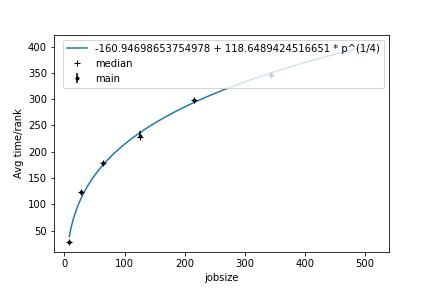
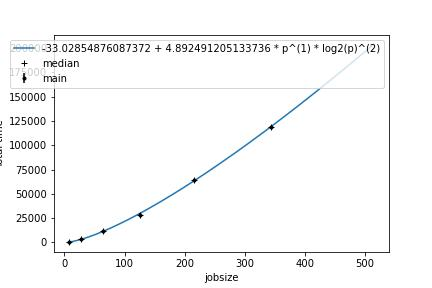
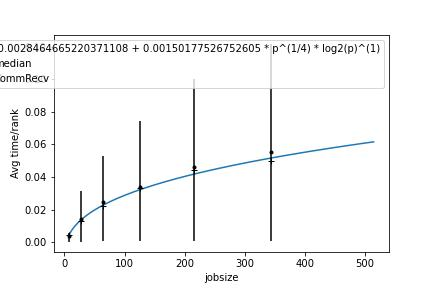
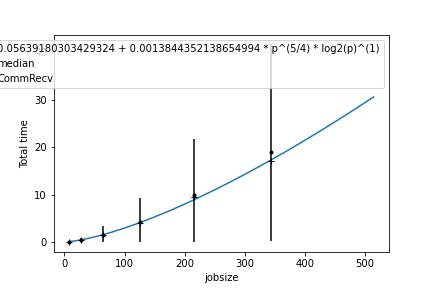
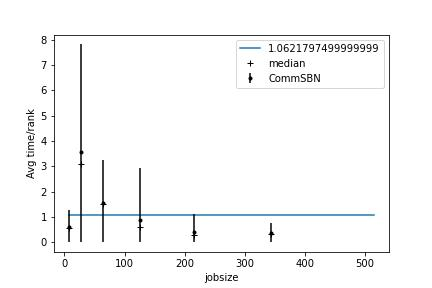
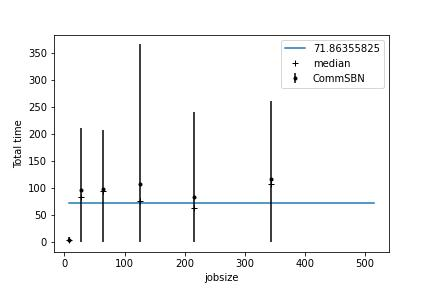
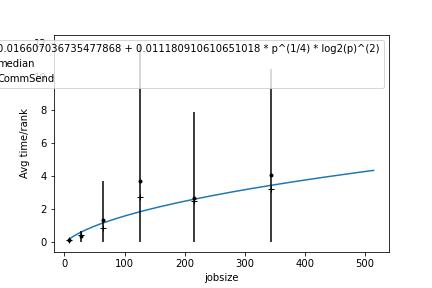
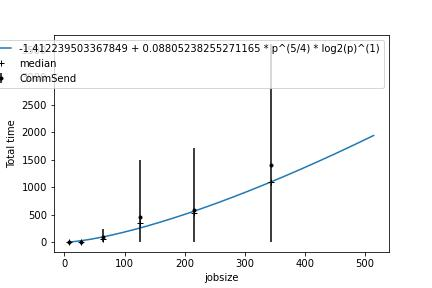
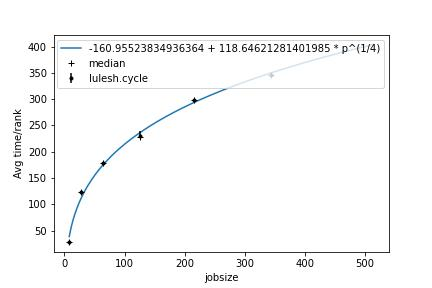
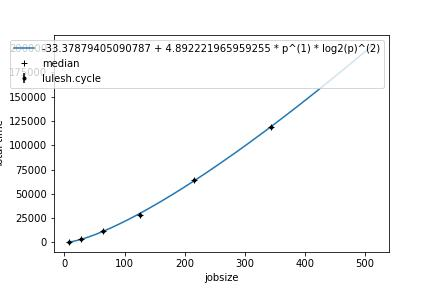
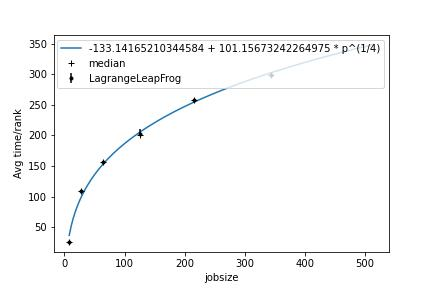
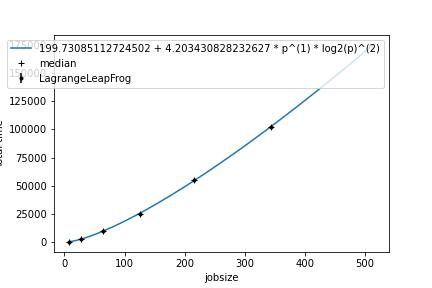
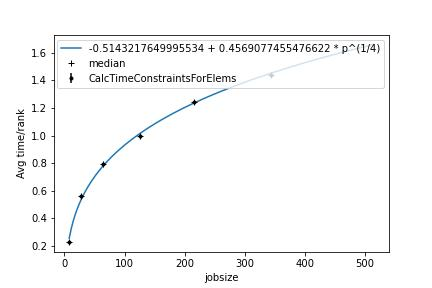
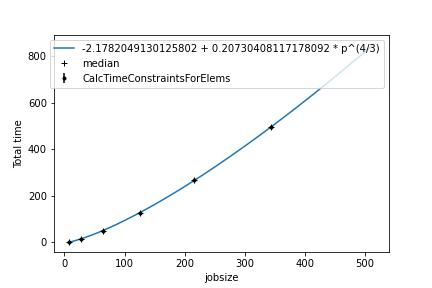
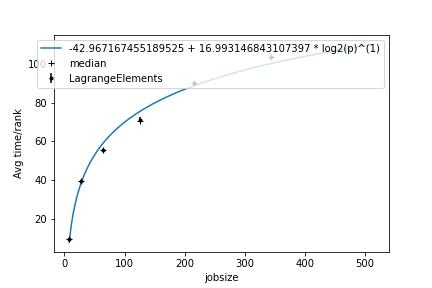
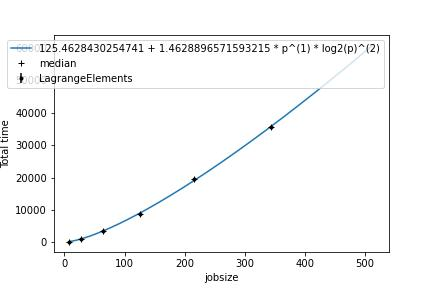
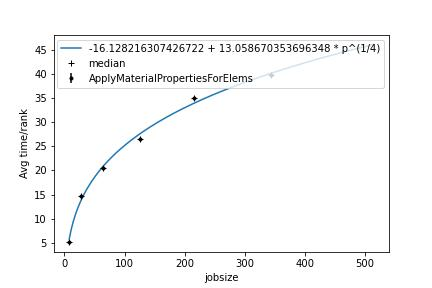
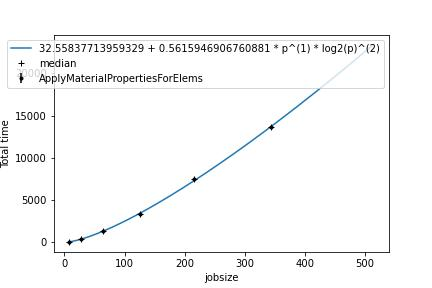
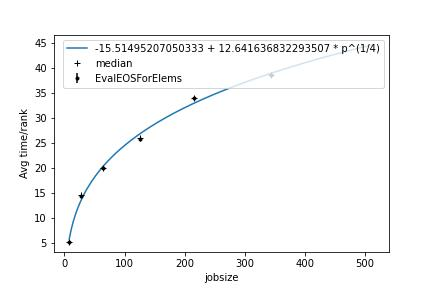
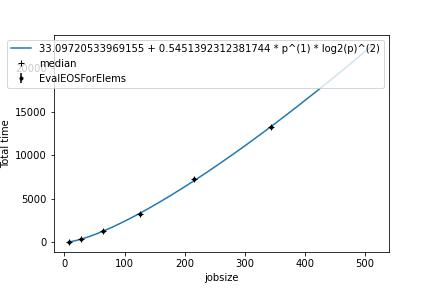
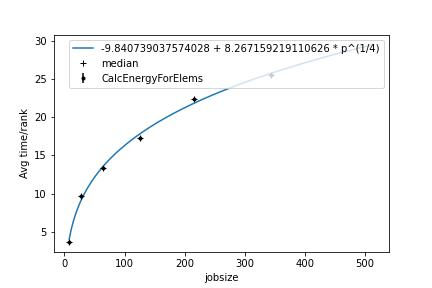
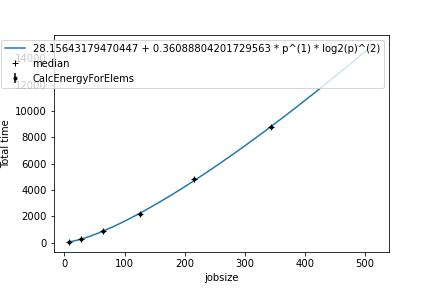
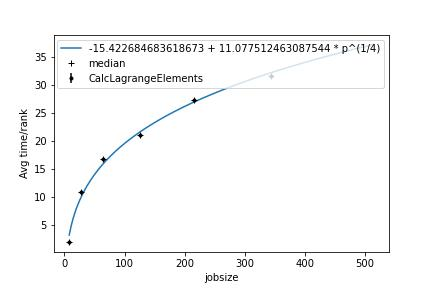
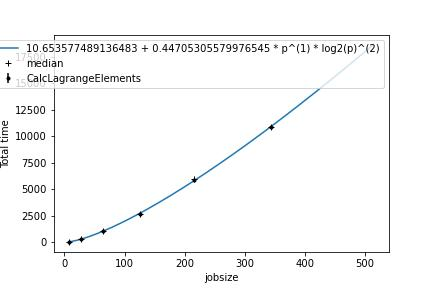
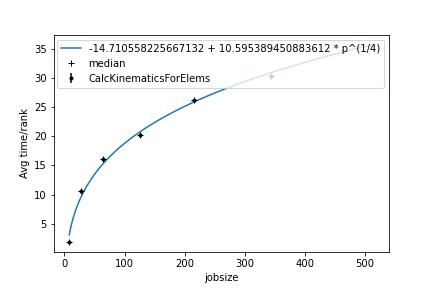
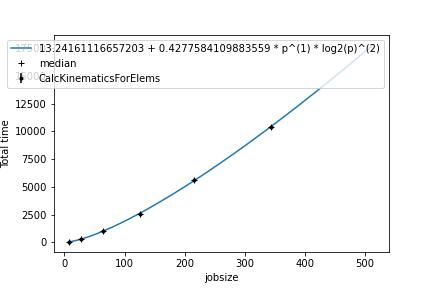
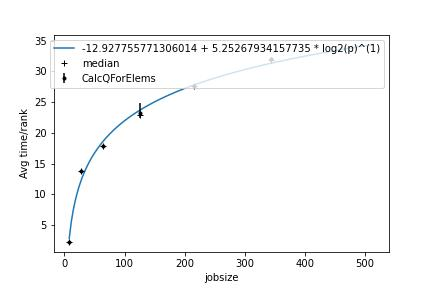
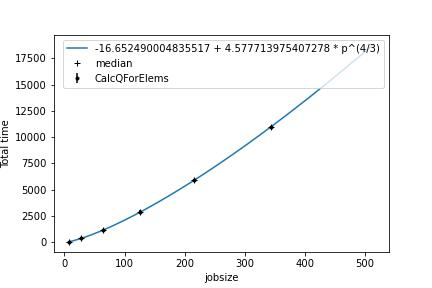
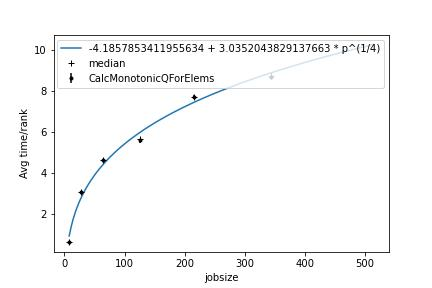
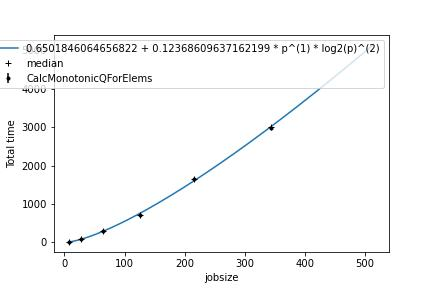
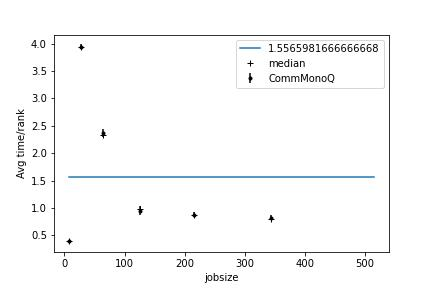
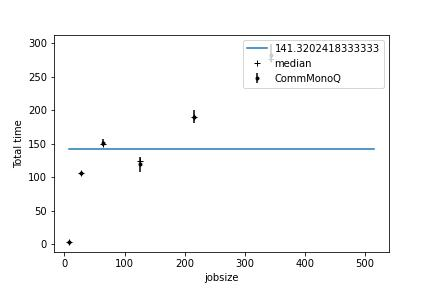
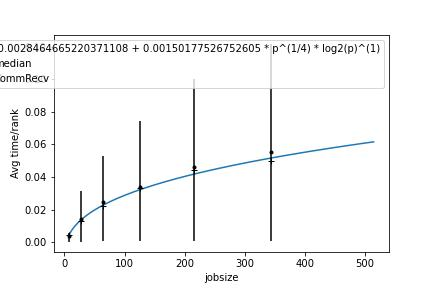
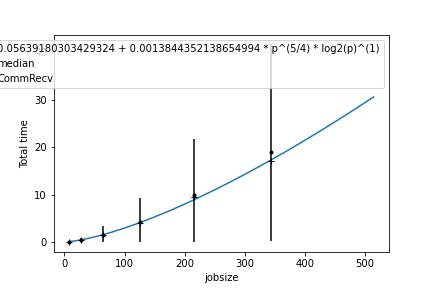
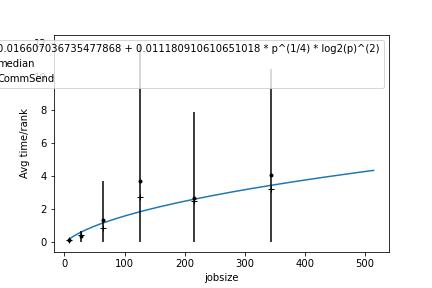
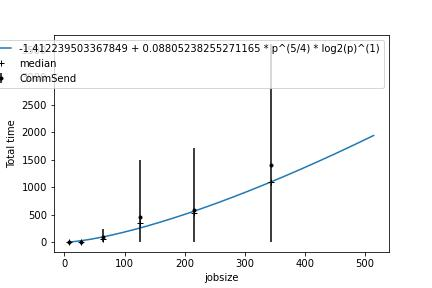
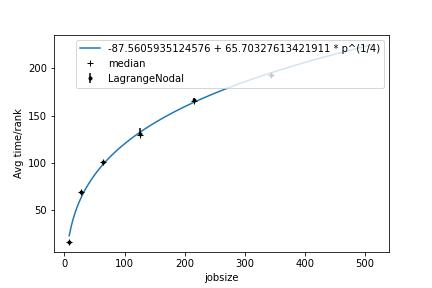
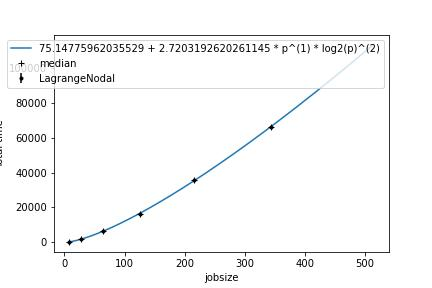
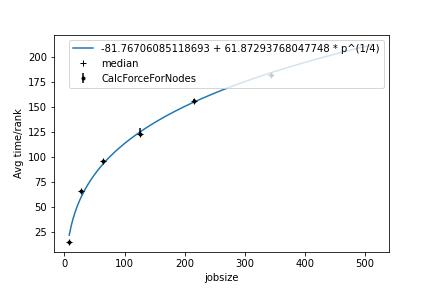
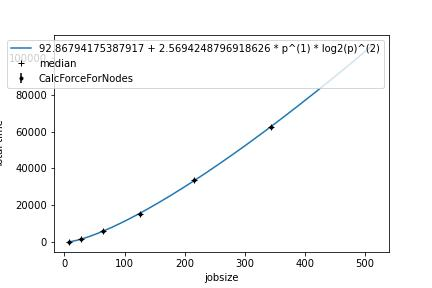
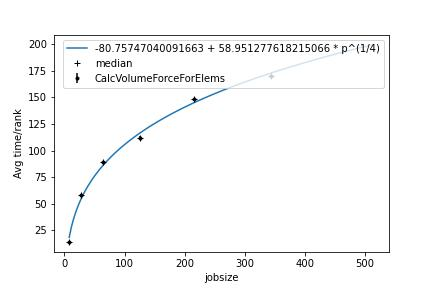
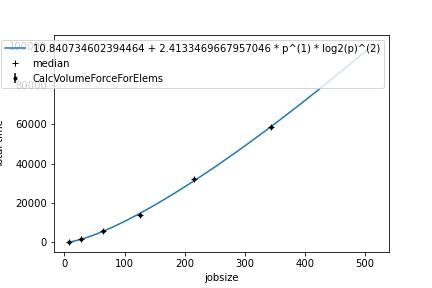
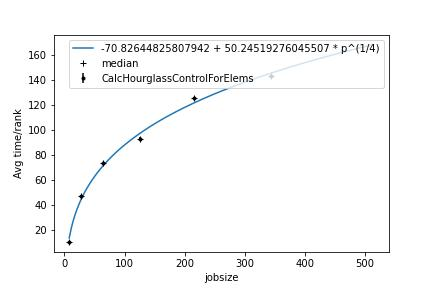
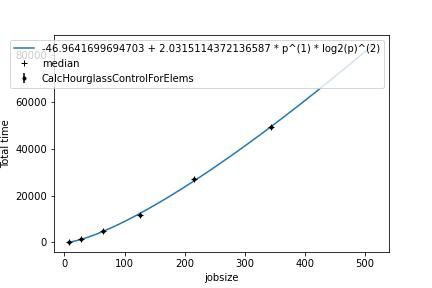
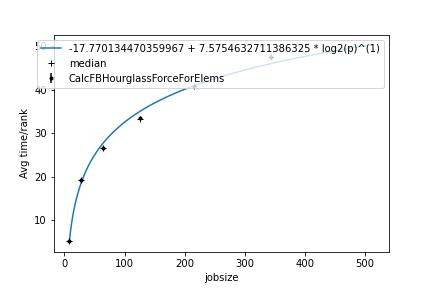
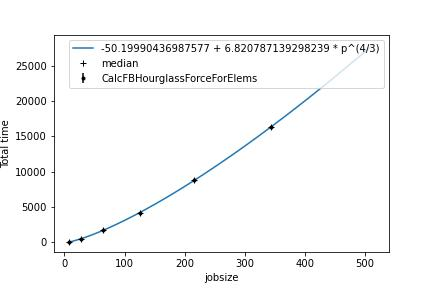
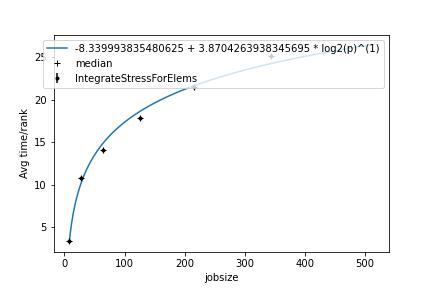
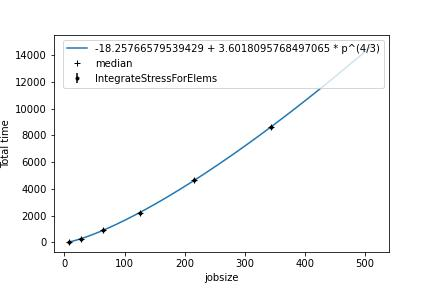
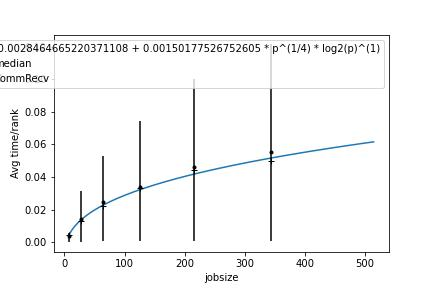
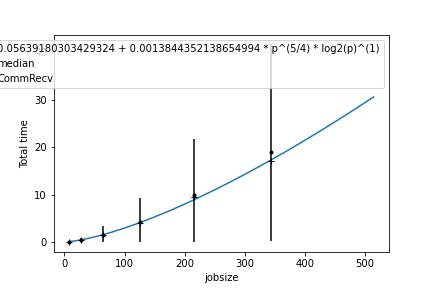
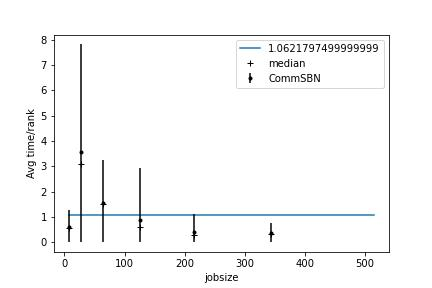
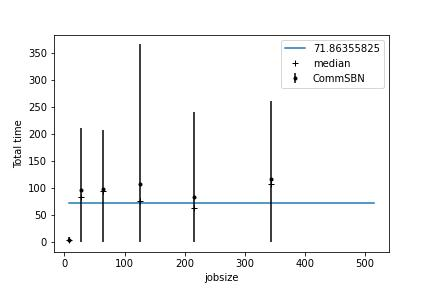
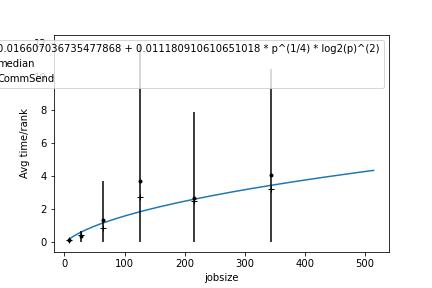
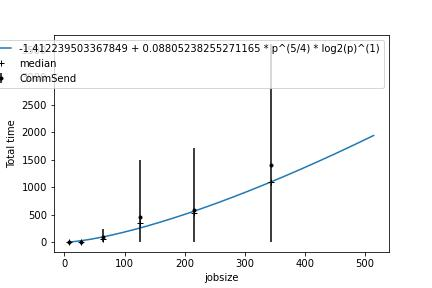
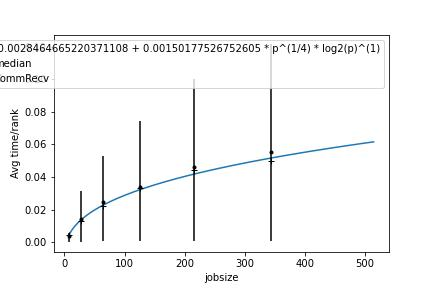
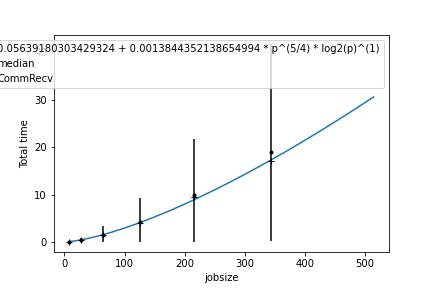
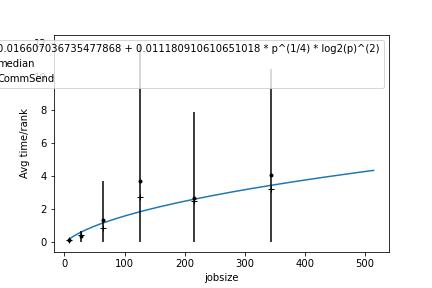
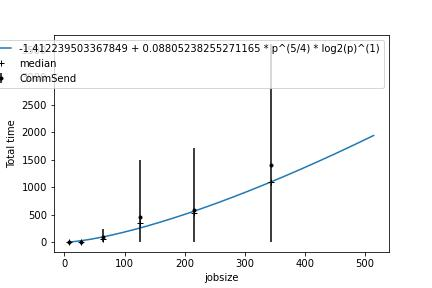
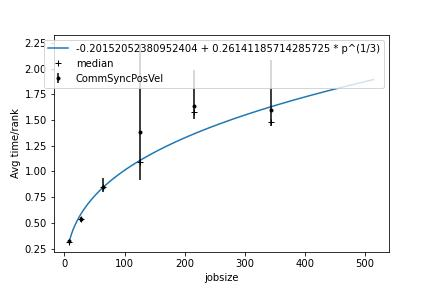
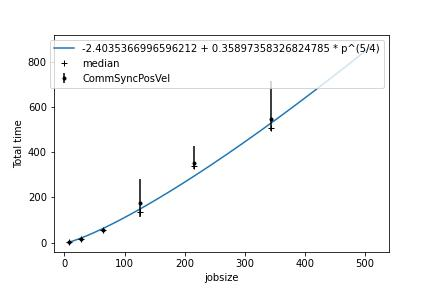
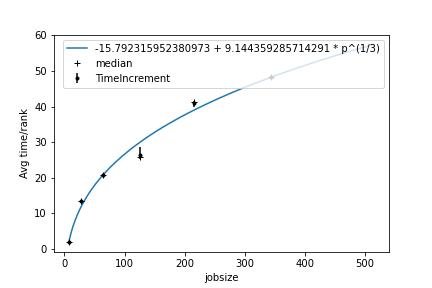
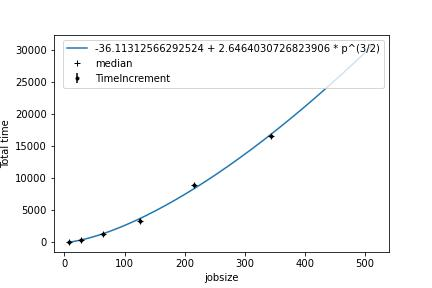

In [39]:
with pd.option_context("display.max_colwidth", 1):
    display(HTML(mdl.to_html()))

## 6. Query Specific Model

The 1st node `{"name": "MPI_Allreduce", "type": "function"}`, has an interesting graph so we want to retrieve its model. This can be achieved by indexing the `models_df` DataFrame for our chosen node for the metric `Avg time/rank_extrap-model`.

In [41]:
model_obj = t_ens.statsframe.dataframe.at[t_ens.statsframe.dataframe.index[0], "Avg time/rank_extrap-model"]

## 7. Operations on a model

We can evaluate the model at a value like a function.

In [43]:
model_obj.eval(600)

426.27415666597375

### Displaying the model:

It returns a _figure_ and an _axis_ objects. The axis object can be used to adjust the plot, i.e., change labels. The `display()` function requires an input for `RSS` (bool), that determines whether to display Extra-P RSS on the plot.

<Figure size 432x288 with 0 Axes>

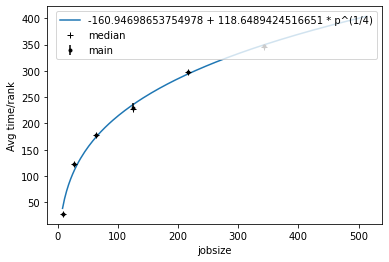

In [45]:
plt.clf()
fig, ax = model_obj.display(RSS=False)
plt.show()
plt.close()

## 8. Weak and strong scaling support

Extra-P can model measurement data from weak and strong scaling experiments. The examples shown in the previous cells all used weak scaling. To create a model using data from a strong scaling experiment, we first load the data.

In [29]:
data = "../data/lulesh/strong"
t_ens = th.Thicket.from_caliperreader(data)

### Creating models using strong scaling:

Next, we have to construct the `Modeling` object again. As before we provide `jobsize` as the `param_name` argument so the model will grab this column from the metadata table to use as our parameter. We also sub-select the metrics *Avg time/rank* and *Total time*.

Then, we call `produce_models()` on that object to create the performance models. 

Now to properly display the strong scaling data and to create models, Extra-P internally converts the strong scaling dataset into a weak scaling experiment. To use this functionality we simply have to set the scaling parameter of the `produce_models()` function to `scaling="strong"`. In addition we need to specify the scaling parameter of the performance experiment, which is usually the resource allocation, e.g., the number of MPI ranks. In this example the *jobsize* corresponds to the number of MPI ranks the application was executed with. Therefore, we set `scaling_parameter="jobsize"` accordingly. Based on this information Extra-P multiplies the measured metric values with the number of MPI ranks, to convert the data from a weak into a strong scaling experiment. Though, this is only done for metrics that are measured per rank, e.g., the *Avg time/rank*. This conversion does not apply to metrics such as the *Total time*.

If the `scaling` and `scaling_parameter` parameters of the `produce_models()` function are not specified, the data will be automatically read as a weak scaling experiment.

In [30]:
mdl = Modeling(
    t_ens,
    "jobsize",
    chosen_metrics=[
        "Avg time/rank",
        "Total time",
    ],
)

mdl.produce_models(use_median=True, scaling="strong", scaling_parameter="jobsize")

self.param_name: jobsize
coordinates: [Coordinate(125.0,), Coordinate(8.0,), Coordinate(64.0,), Coordinate(27.0,), Coordinate(343.0,), Coordinate(216.0,)]
len coordinates: 6
Callpaths: [Callpath(main), Callpath(CommRecv), Callpath(CommSBN), Callpath(CommSend), Callpath(lulesh.cycle), Callpath(LagrangeLeapFrog), Callpath(CalcTimeConstraintsForElems), Callpath(LagrangeElements), Callpath(ApplyMaterialPropertiesForElems), Callpath(EvalEOSForElems), Callpath(CalcEnergyForElems), Callpath(CalcLagrangeElements), Callpath(CalcKinematicsForElems), Callpath(CalcQForElems), Callpath(CalcMonotonicQForElems), Callpath(CommMonoQ), Callpath(LagrangeNodal), Callpath(CalcForceForNodes), Callpath(CalcVolumeForceForElems), Callpath(CalcHourglassControlForElems), Callpath(CalcFBHourglassForceForElems), Callpath(IntegrateStressForElems), Callpath(CommSyncPosVel), Callpath(TimeIncrement)]
Metrics: [Metric(Avg time/rank), Metric(Total time)]
str(metric): Avg time/rank
ranks: 125.0
str(metric): Avg time/rank

### Analyzing a strong scaling experiment

Subesequently, we can analyze the data as before. We can take a look at thicket's aggregated statistics table or show the models dataframe with the embedded plots.

In [31]:
t_ens.statsframe.dataframe

,name,Avg time/rank_extrap-model,Avg time/rank_RSS_extrap-model,Avg time/rank_rRSS_extrap-model,Avg time/rank_SMAPE_extrap-model,Avg time/rank_AR2_extrap-model,Avg time/rank_RE_extrap-model,Total time_extrap-model,Total time_RSS_extrap-model,Total time_rRSS_extrap-model,Total time_SMAPE_extrap-model,Total time_AR2_extrap-model,Total time_RE_extrap-model
node,,,,,,,,,,,,,
"{'name': 'main', 'type': 'function'}",main,-561.8317708308057 + 486.64100067447237 * p^(1/4),108127.513302,0.197867,18.063053,0.884946,0.153026,-561.8317119517437 + 486.6409759202624 * p^(1/4),108127.505764,0.197867,18.063055,0.884946,0.153026
"{'name': 'CommRecv', 'type': 'function'}",CommRecv,0.024260378422739447 + 0.00039598712775724325 ...,0.012960,0.105481,13.097851,0.988300,0.104523,0.02426269705179783 + 0.000395980163250897 * p...,0.012974,0.105542,13.101269,0.988287,0.104551
"{'name': 'CommSBN', 'type': 'function'}",CommSBN,6.1456219999999995,205.586865,7.805010,64.503092,1.000000,1.548202,6.145628833333333,205.586658,7.804934,64.502937,1.000000,1.548129
"{'name': 'CommSend', 'type': 'function'}",CommSend,0.7370310097251698 + 0.01639646042535728 * p^(...,15.172398,0.182106,19.693291,0.943757,0.165481,0.7370230057518413 + 0.01639643583450623 * p^(...,15.172917,0.182109,19.693681,0.943755,0.165484
"{'name': 'lulesh.cycle', 'type': 'function'}",lulesh.cycle,-559.5022507199732 + 485.51857333691873 * p^(1/4),107917.105773,0.201398,18.124848,0.884649,0.153769,-559.5021893221214 + 485.51854677035845 * p^(1/4),107917.130062,0.201398,18.124851,0.884649,0.153769
"{'name': 'LagrangeLeapFrog', 'type': 'function'}",LagrangeLeapFrog,-258.30096161217904 + 156.30158185934113 * log...,118424.279056,0.156942,18.291172,0.729735,0.148258,-258.3009986457773 + 156.30158915524694 * log2...,118424.336814,0.156942,18.291172,0.729735,0.148258
"{'name': 'CalcTimeConstraintsForElems', 'type': 'function'}",CalcTimeConstraintsForElems,1.3822388544252349 + 0.04863652194751138 * p^(...,7.413757,0.082891,10.667412,0.987705,0.090971,1.382211893844543 + 0.048636719898429076 * p^(...,7.413584,0.082882,10.667008,0.987705,0.090966
"{'name': 'LagrangeElements', 'type': 'function'}",LagrangeElements,-12.30756761483944 + 17.899276629990855 * p^(1...,28904.271782,0.171095,18.997777,0.842693,0.150553,-12.307556039177696 + 17.899275922050037 * p^(...,28904.303367,0.171095,18.997782,0.842693,0.150553
"{'name': 'ApplyMaterialPropertiesForElems', 'type': 'function'}",ApplyMaterialPropertiesForElems,14.970266658112992 + 5.969830402801105 * p^(3/4),5322.415026,0.090452,12.408115,0.954521,0.098806,14.97026928949793 + 5.969829599688274 * p^(3/4),5322.410114,0.090452,12.408118,0.954521,0.098806


When analyzing the models dataframe with the embedded plots, we see that models for the metrics *Avg time/rank, Total time*. are almost perfectly identical. This should be the case and indicates that the strong scaling data was correctly converted into a weak scaling experiment.

In this case both metrics are showing redundant information as we intentionally measured the total time to highlight the conversion process. In reality the *Total time* might not be available as a metric. 

,Avg time/rank_extrap-model,Total time_extrap-model
node,,
"{'name': 'main', 'type': 'function'}",,
"{'name': 'CommRecv', 'type': 'function'}",,
"{'name': 'CommSBN', 'type': 'function'}",,
"{'name': 'CommSend', 'type': 'function'}",,
"{'name': 'lulesh.cycle', 'type': 'function'}",,
"{'name': 'LagrangeLeapFrog', 'type': 'function'}",,
"{'name': 'CalcTimeConstraintsForElems', 'type': 'function'}",,
"{'name': 'LagrangeElements', 'type': 'function'}",,
"{'name': 'ApplyMaterialPropertiesForElems', 'type': 'function'}",,

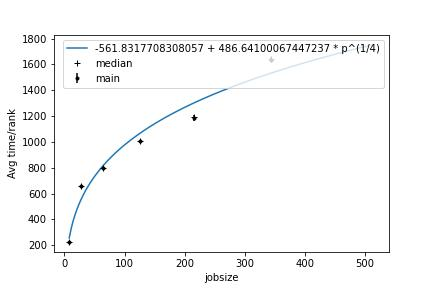
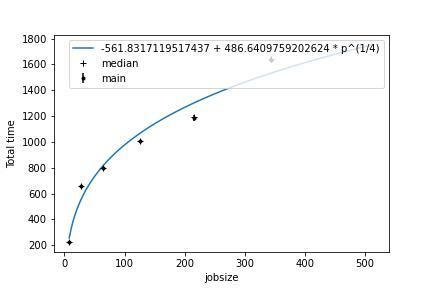
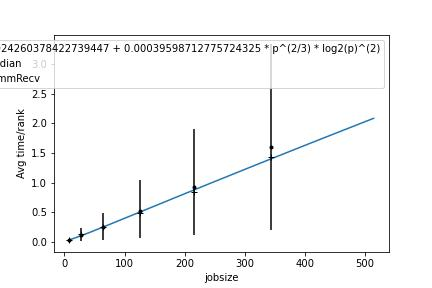
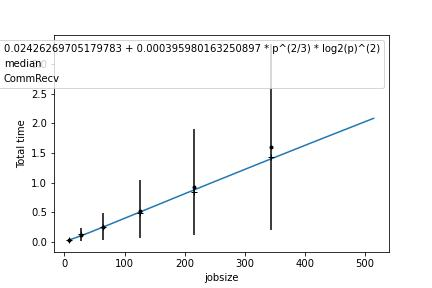
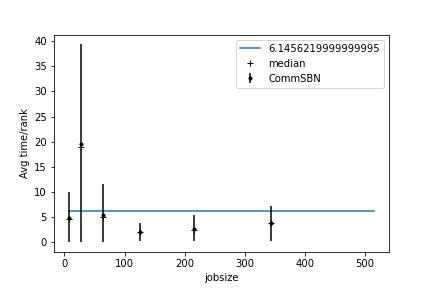
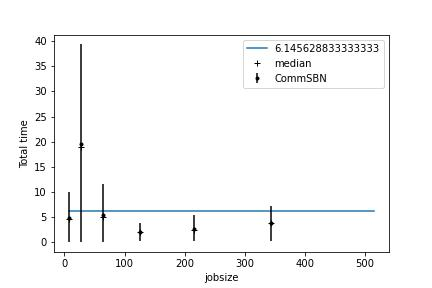
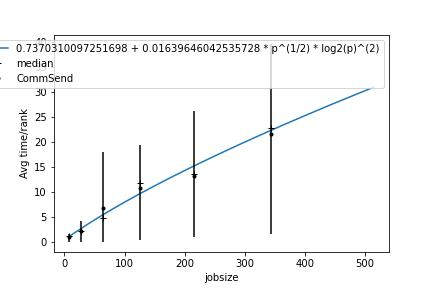
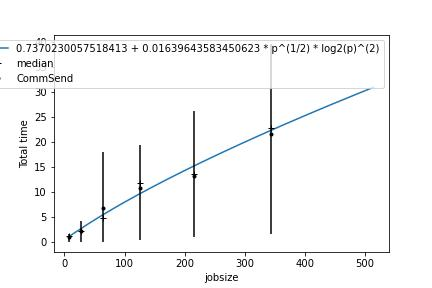
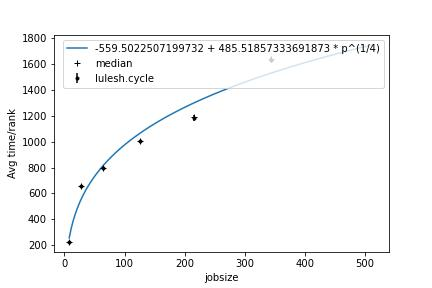
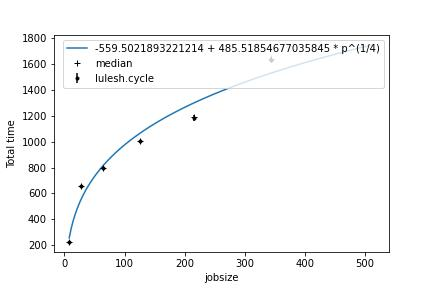
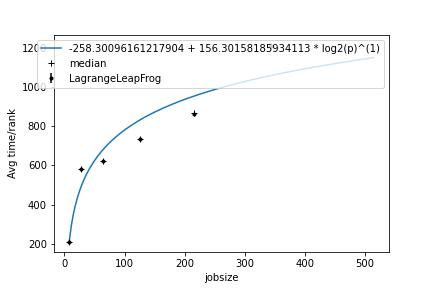
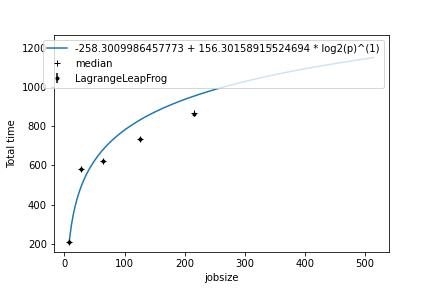
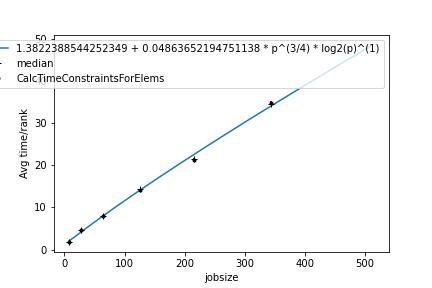
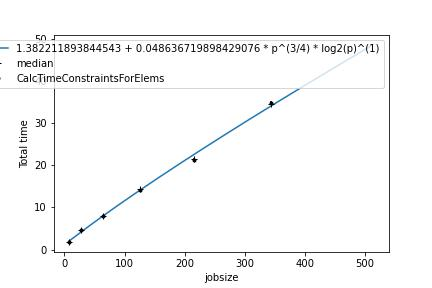
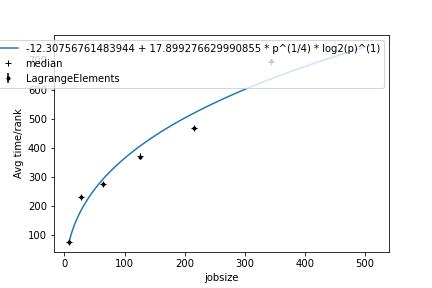
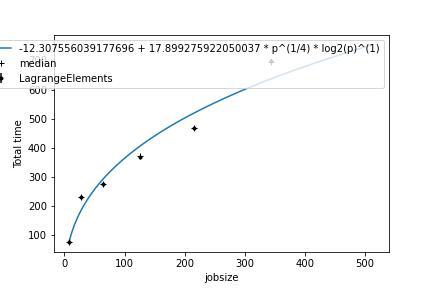
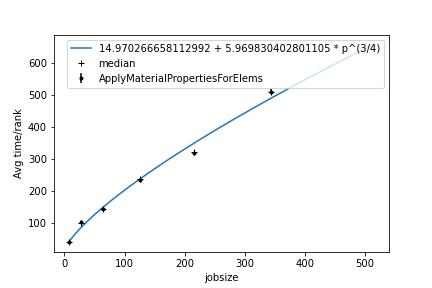
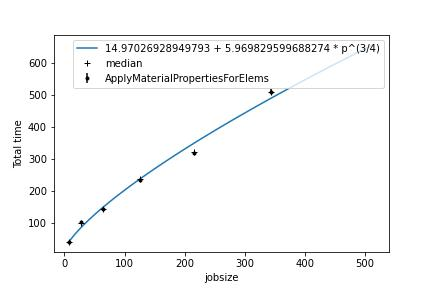
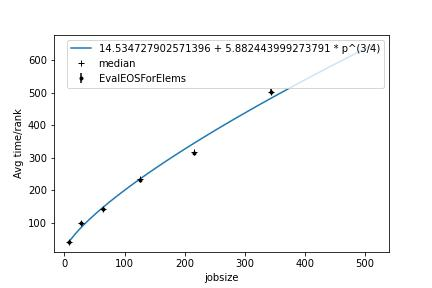
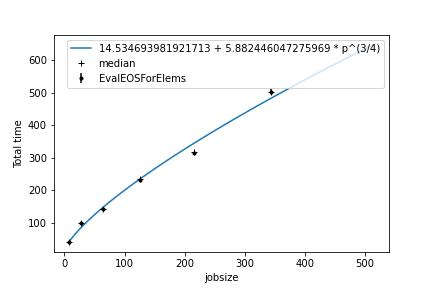
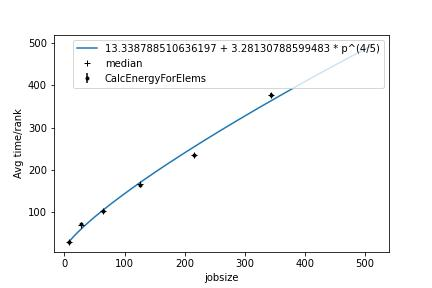
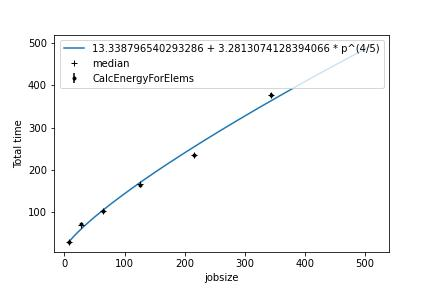
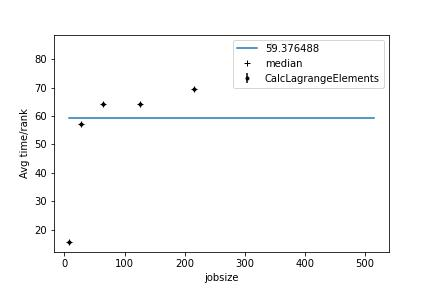
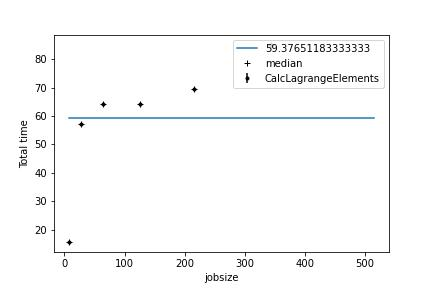
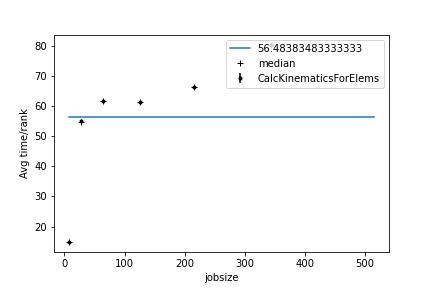
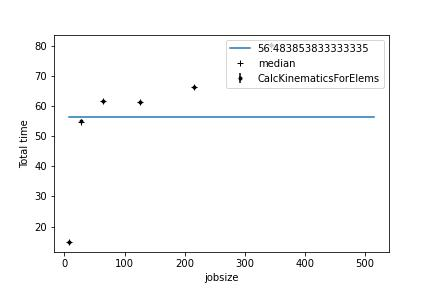
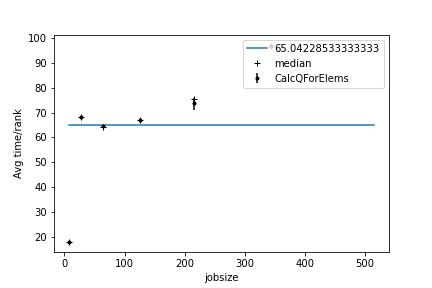
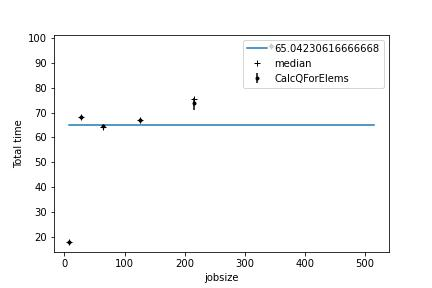
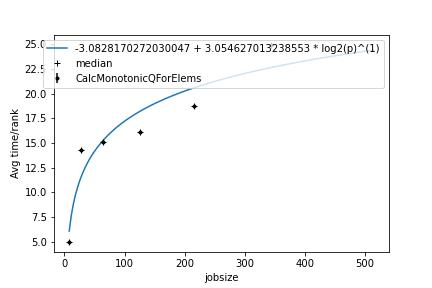
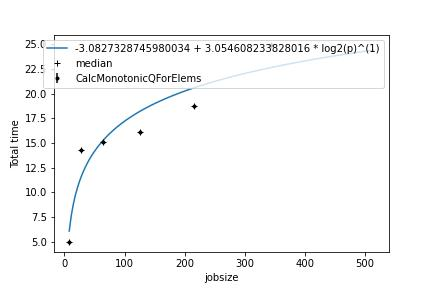
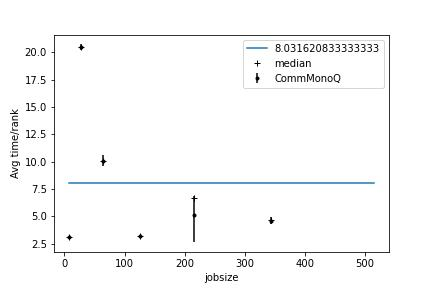
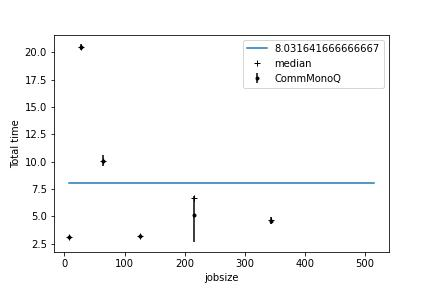
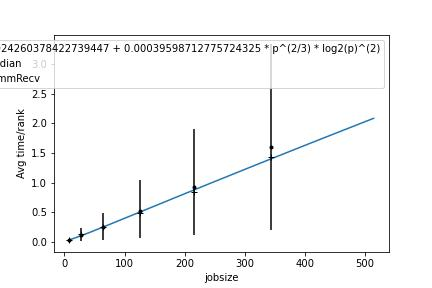
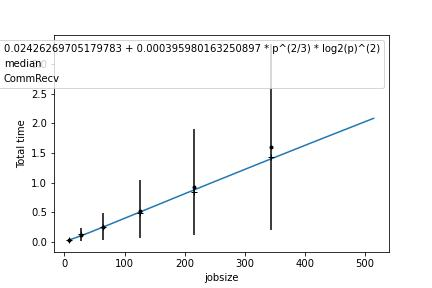
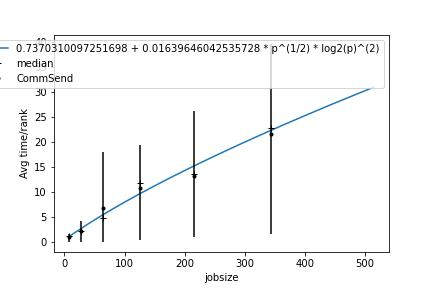
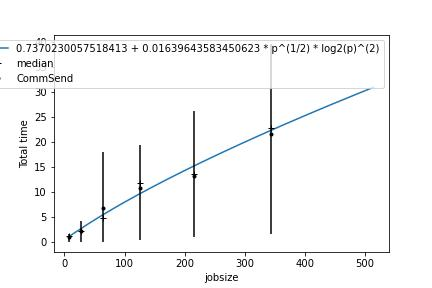
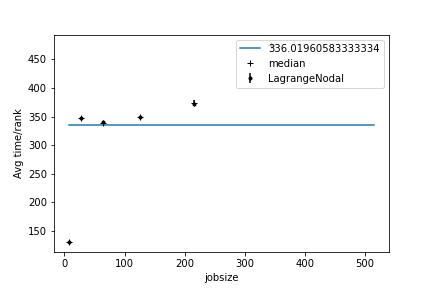
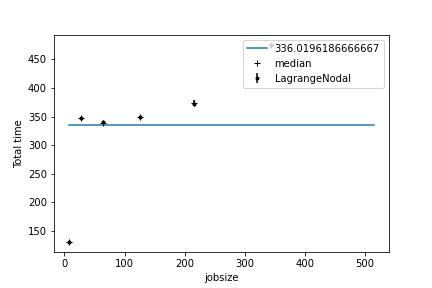
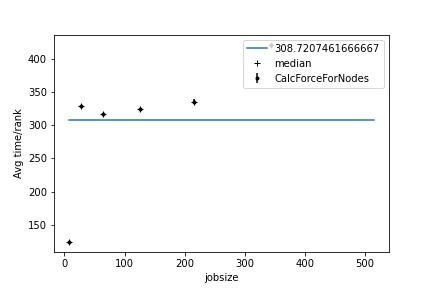
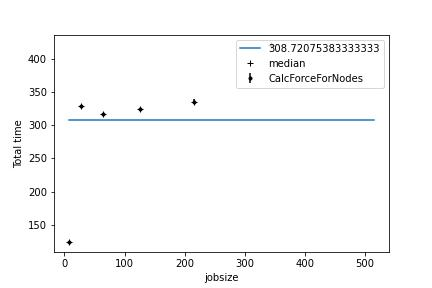
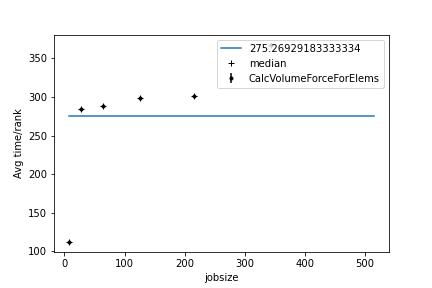
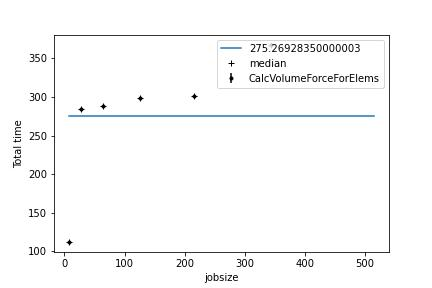
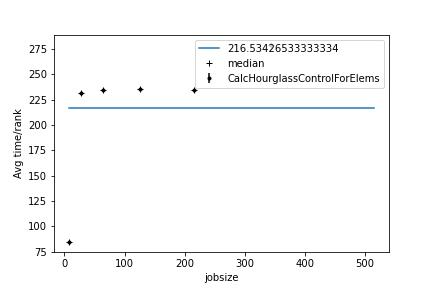
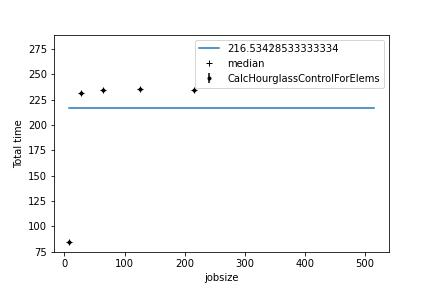
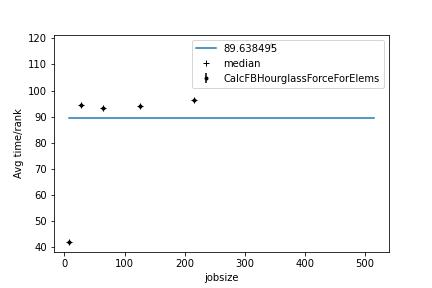
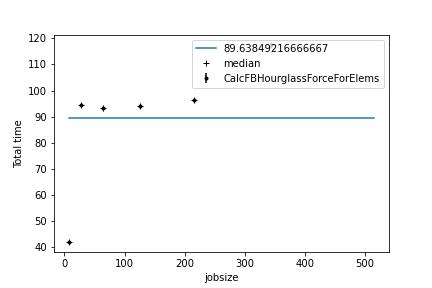
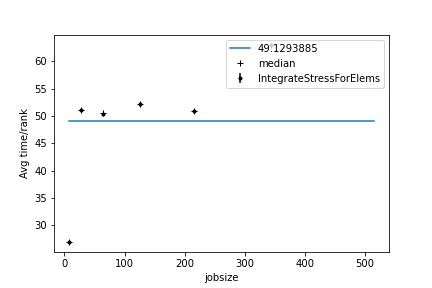
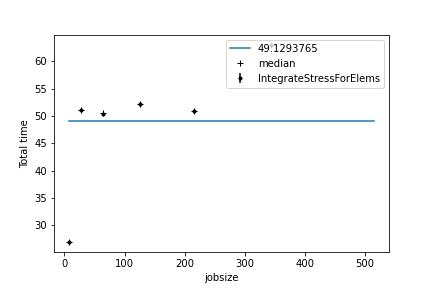
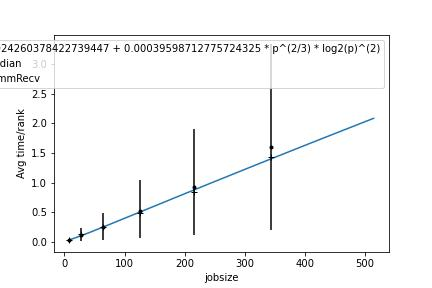
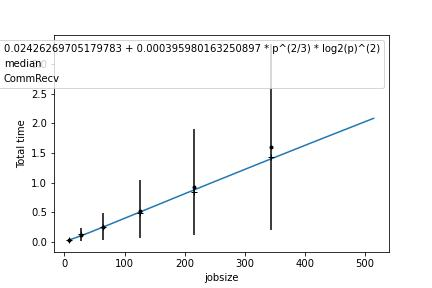
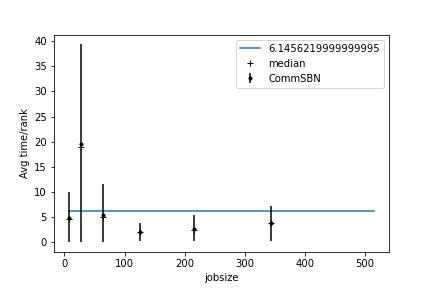
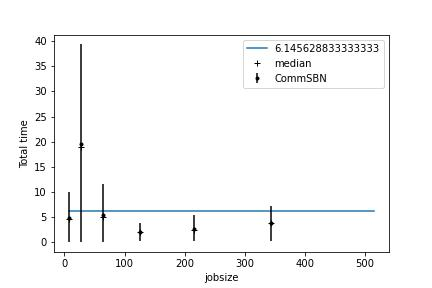
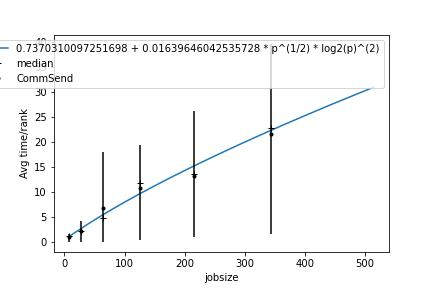
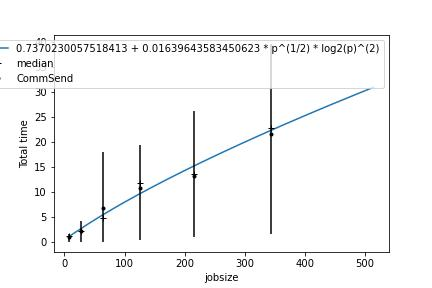
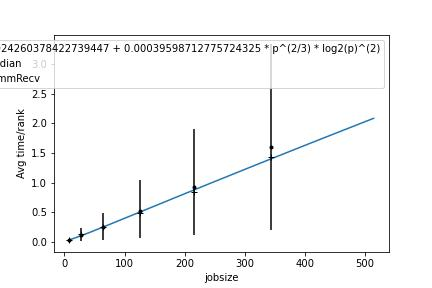
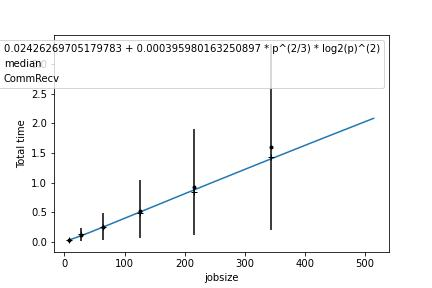
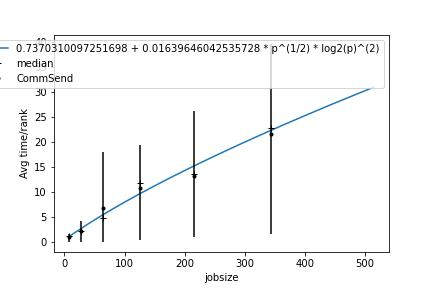
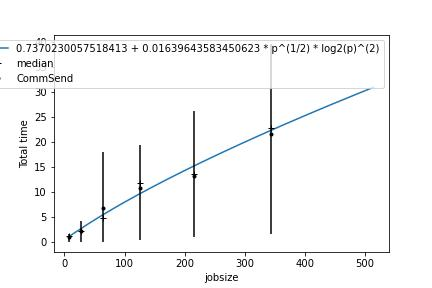
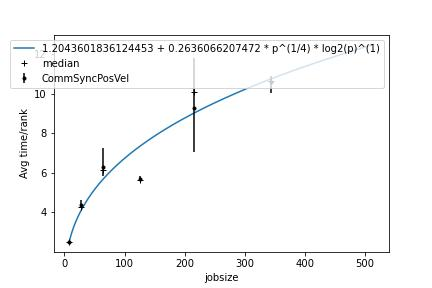
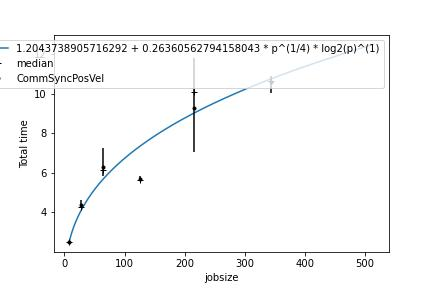
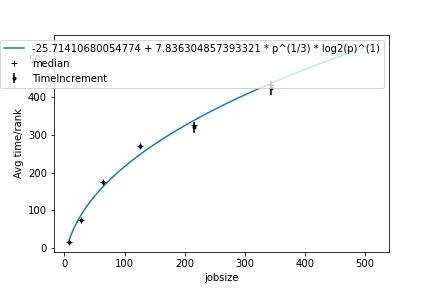
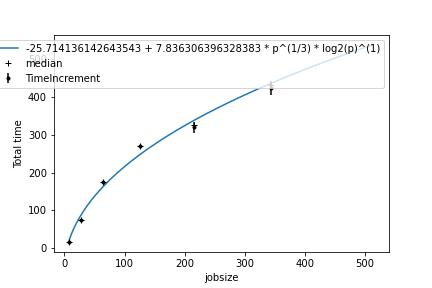

In [32]:
with pd.option_context("display.max_colwidth", 1):
    display(HTML(mdl.to_html()))